## APO: Alibaba Price Oracle
We load the trained model and the test dataset.

As a reminder, the input to APO is 7 days price history of the market, and the output is a reconstruction of these 7 days and 7 days prediction of the future.

APO relies only on feedforward, self attention elements to learn first dynamics of the airline prices exclusively then share this knowledge with the whole market in another set of self attention layers. 

In [1]:
import os.path as osp
import os

import seaborn as sns
import torch
from loguru import logger
from torch.utils.data import DataLoader

from alibaba_ai_task.models.apo_model import APO
from alibaba_ai_task.tools.model_loader import load_model
from alibaba_ai_task.tools.omni_tools import copy2cpu as c2c
from alibaba_ai_task.tools.omni_tools import get_support_data_dir
from alibaba_ai_task.train.data_module import PriceDataLoader

import numpy as np

from matplotlib import pyplot as plt

sns.set(rc={'figure.figsize':(11, 4)})

support_dir = get_support_data_dir()

In [2]:
expr_id = 'V01'
data_id = 'V01'

work_base_dir = '/home/nghorbani/Desktop/alibaba_ai_task'
expr_dir = osp.join(work_base_dir, 'training_experiments', f'{data_id}', expr_id)

split_name = 'test'
dataset_dir = osp.join(work_base_dir, 'data', data_id, split_name)

In [3]:
apo_model, model_cfg = load_model(expr_dir, model_code=APO,
                                  remove_words_in_model_weights='model.',
                                  model_cfg_override={
                                      'dirs.work_base_dir': work_base_dir,
                                      'dirs.support_base_dir': support_dir},
                                  comp_device='gpu')

2021-11-20 02:51:44.715 | INFO     | alibaba_ai_task.tools.model_loader:load_model:82 - Loaded model in eval mode with trained weights: /home/nghorbani/Desktop/alibaba_ai_task/training_experiments/V01/V01/snapshots/V01_epoch=24_val_loss=602707.38.ckpt


In [4]:
dataset = PriceDataLoader(dataset_dir=dataset_dir)

dl = DataLoader(dataset,
           batch_size=5, # using BN
           drop_last=False,
           shuffle=False,
           num_workers=4,
           pin_memory=True)

2021-11-20 02:51:44.728 | DEBUG    | alibaba_ai_task.train.data_module:__init__:43 - dimensions of loaded data: {'price': torch.Size([113, 14, 14, 2])}
2021-11-20 02:51:44.729 | DEBUG    | alibaba_ai_task.train.data_module:__init__:48 - Split test: Loaded #113 data points from dataset_dir /home/nghorbani/Desktop/alibaba_ai_task/data/V01/test.


In [5]:
logger.info(f'Model trained with the following configuration {model_cfg}')

2021-11-20 02:51:44.736 | INFO     | __main__:<module>:1 - Model trained with the following configuration {'apo': {'expr_id': 'V01', 'data_id': 'V01'}, 'dirs': {'work_base_dir': '/home/nghorbani/Desktop/alibaba_ai_task', 'support_base_dir': '/is/ps3/nghorbani/code-repos/alibab_ai_task/support_data', 'work_dir': '${dirs.work_base_dir}/training_experiments/${apo.data_id}/${apo.expr_id}', 'log_dir': '${dirs.work_dir}/logs', 'log_fname': '${dirs.log_dir}/${apo.expr_id}_${apo.data_id}.log', 'cfg_fname': '${dirs.work_dir}/${apo.expr_id}_${apo.data_id}.yaml', 'dataset_dir': '${dirs.work_base_dir}/data/${apo.data_id}'}, 'train_parms': {'batch_size': 16, 'num_workers': 6, 'loss_weights': {'price': 1.0}, 'optimizer': {'type': 'Adam', 'args': {'lr': 0.001, 'weight_decay': 5e-05, 'betas': [0.9, 0.999]}}, 'lr_scheduler': {'type': 'ReduceLROnPlateau', 'args': {'verbose': True, 'patience': 3}}, 'early_stopping': {'monitor': 'val_loss', 'min_delta': 0.0, 'patience': 8, 'verbose': True, 'mode': 'min'}}

In [6]:
history_length = model_cfg.data_parms.history_length

criteria = torch.nn.L1Loss(reduction='none')

price_diff = []
price_dynamics_att_wts = []
price_market_att_wts = []
for data in dl:
    price_gt = data['price']
    model_out = apo_model(price_gt[:,:history_length])
    
    price_pred = model_out['price']
    diff = criteria(price_pred, price_gt[:,:,:,:1])
    # diff = torch.abs(price_gt - price_pred)
    price_diff.append(diff)
    price_dynamics_att_wts.append(model_out['price_dynamics_att_wts'])
    price_market_att_wts.append(model_out['price_market_att_wts'])
    
price_diff = torch.cat(price_diff, dim=0)
price_dynamics_att_wts = torch.cat(price_dynamics_att_wts, dim=0)
price_market_att_wts = torch.cat(price_market_att_wts, dim=0)

price_diff_mean = c2c(price_diff[:,:,:,0].mean(0))
price_dynamics_att_wts_mean = c2c(price_dynamics_att_wts.mean(0))
price_market_att_wts_mean = c2c(price_market_att_wts.mean(0))

logger.info(f'price_diff_mean.shape:  {price_diff_mean.shape}')
logger.info(f'price_dynamics_att_wts_mean.shape:  {price_dynamics_att_wts_mean.shape}')
logger.info(f'price_market_att_wts_mean.shape:  {price_market_att_wts_mean.shape}')

logger.info('Mean absolute {} data difference on history reconstruction: {}'.format(split_name, price_diff[:,:history_length].mean()))
logger.success('Mean absolute {} data difference on future prediction: {}'.format(split_name, price_diff[:,history_length:].mean()))
logger.info('Mean absolute {} data in total: {}'.format(split_name, price_diff.mean()))

2021-11-20 02:51:45.798 | INFO     | __main__:<module>:27 - price_diff_mean.shape:  (14, 14)
2021-11-20 02:51:45.800 | INFO     | __main__:<module>:28 - price_dynamics_att_wts_mean.shape:  (3, 5, 7, 7)
2021-11-20 02:51:45.802 | INFO     | __main__:<module>:29 - price_market_att_wts_mean.shape:  (3, 5, 14, 14)
2021-11-20 02:51:45.804 | INFO     | __main__:<module>:31 - Mean absolute test data difference on history reconstruction: 492811.78125
2021-11-20 02:51:45.806 | SUCCESS  | __main__:<module>:32 - Mean absolute test data difference on future prediction: 729284.25
2021-11-20 02:51:45.808 | INFO     | __main__:<module>:33 - Mean absolute test data in total: 611047.9375


The shape for 'price_dynamics_att_wts_mean' reflect number of attentions layers and number of attention head. We will visualize these weights next.

In [7]:
time_length, num_airlines = dataset[0]['price'].shape[0:2]
logger.info(f'num_airlines: {num_airlines}')

2021-11-20 02:51:45.817 | INFO     | __main__:<module>:2 - num_airlines: 14


## Results Visualization
The mean error on reconstructed and predicted prices can be visualized as 2D plots. 
Visulization reveals increasing error specially after day 7, i.e. beginging of the price prediction.

Text(0.5, 0, 'Days')

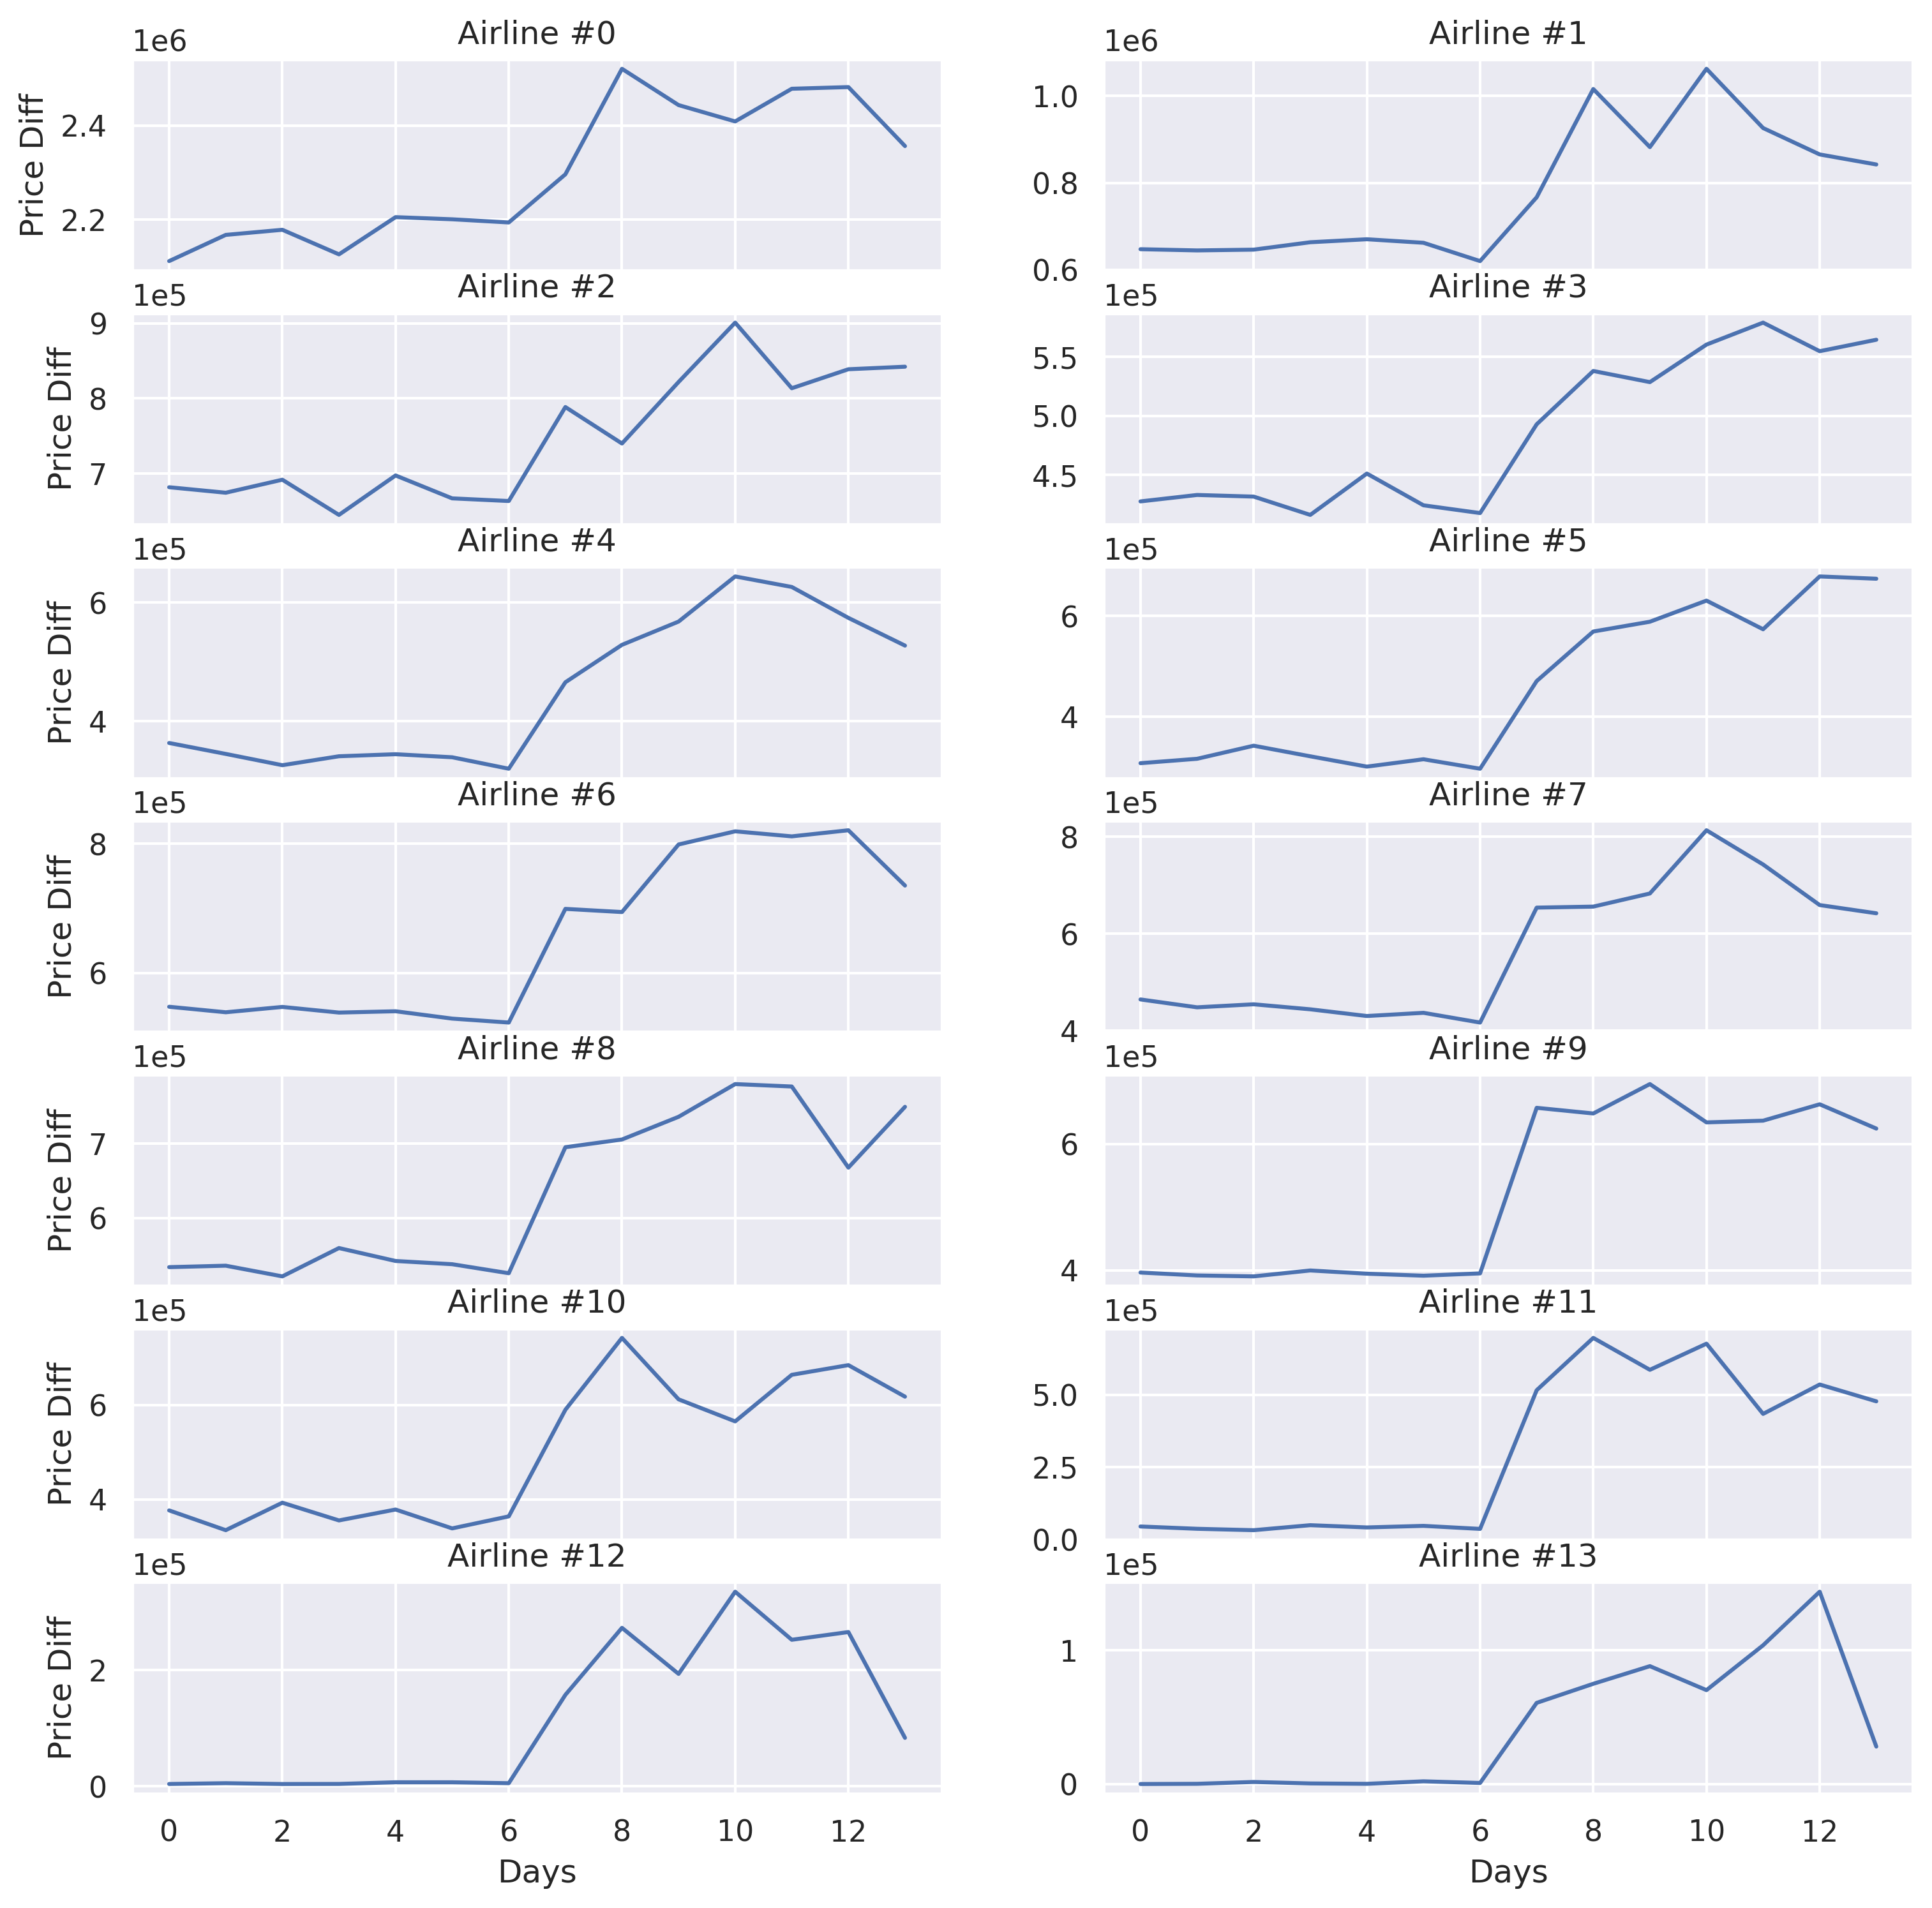

In [8]:
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(12,12), dpi=300, sharex=True)
axs = axs.reshape(-1)
for i in range(num_airlines):
    ax = axs[i]
    line = ax.plot(range(time_length), price_diff_mean[:,i])

    ax.title.set_text(f'Airline #{i}')
    if not i%2:
        ax.set_ylabel('Price Diff')
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useOffset=True)

    # ax.axis('off')

axs[-1].set_xlabel('Days')
axs[-2].set_xlabel('Days')


We can visualize the same data in a more compact heatmap plot. In early days the reconstructed price is closer to the ground-truth. As time goes by, especially after day 7, i.e. at the onset of market price prediction, the error rises rapidly, as expected.

<AxesSubplot:>

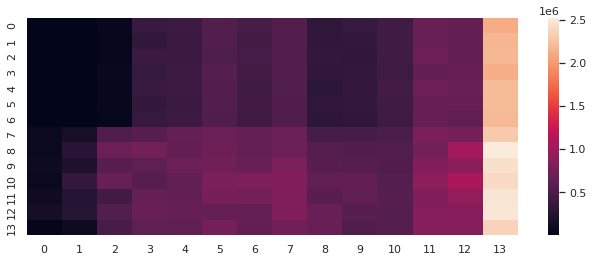

In [9]:
sns.heatmap(price_diff_mean[:,::-1])

Let's see how does it all look in plain numbers. Change 'al' to choose between airlines. All 14 time steps are shown. First 7 are reconstruction of the history and last 7 are the future prices.

In [36]:
al = 0 # airline
bn = 0 #batch number
price_gt[bn,:,al,0]

tensor([3663000., 3102000., 4384000., 3378000., 3378000., 2826000., 2624000.,
        3277000., 2826000., 4924500., 4024000., 3218000., 2826000., 3176000.])

In [37]:
price_pred[bn,:,al,0]

tensor([3237481.7500, 2256078.2500, 3454809.2500, 2869958.7500, 2750699.2500,
        2415854.5000, 2938971.2500, 3241566.0000, 2567664.5000, 3011027.2500,
        3006340.7500, 2957814.0000, 2491591.2500, 2910670.0000])

In [46]:
abs(price_gt[bn,:,al,0] - price_pred[bn,:,al,0]).mean()

tensor(581851.1250)

## Visualizing Attention Weights

### Price Dynamics Attention
Here the goal is to learn changes of the price for each airline individually over time.

/is/ps3/nghorbani/opt/anaconda3/envs/apo/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


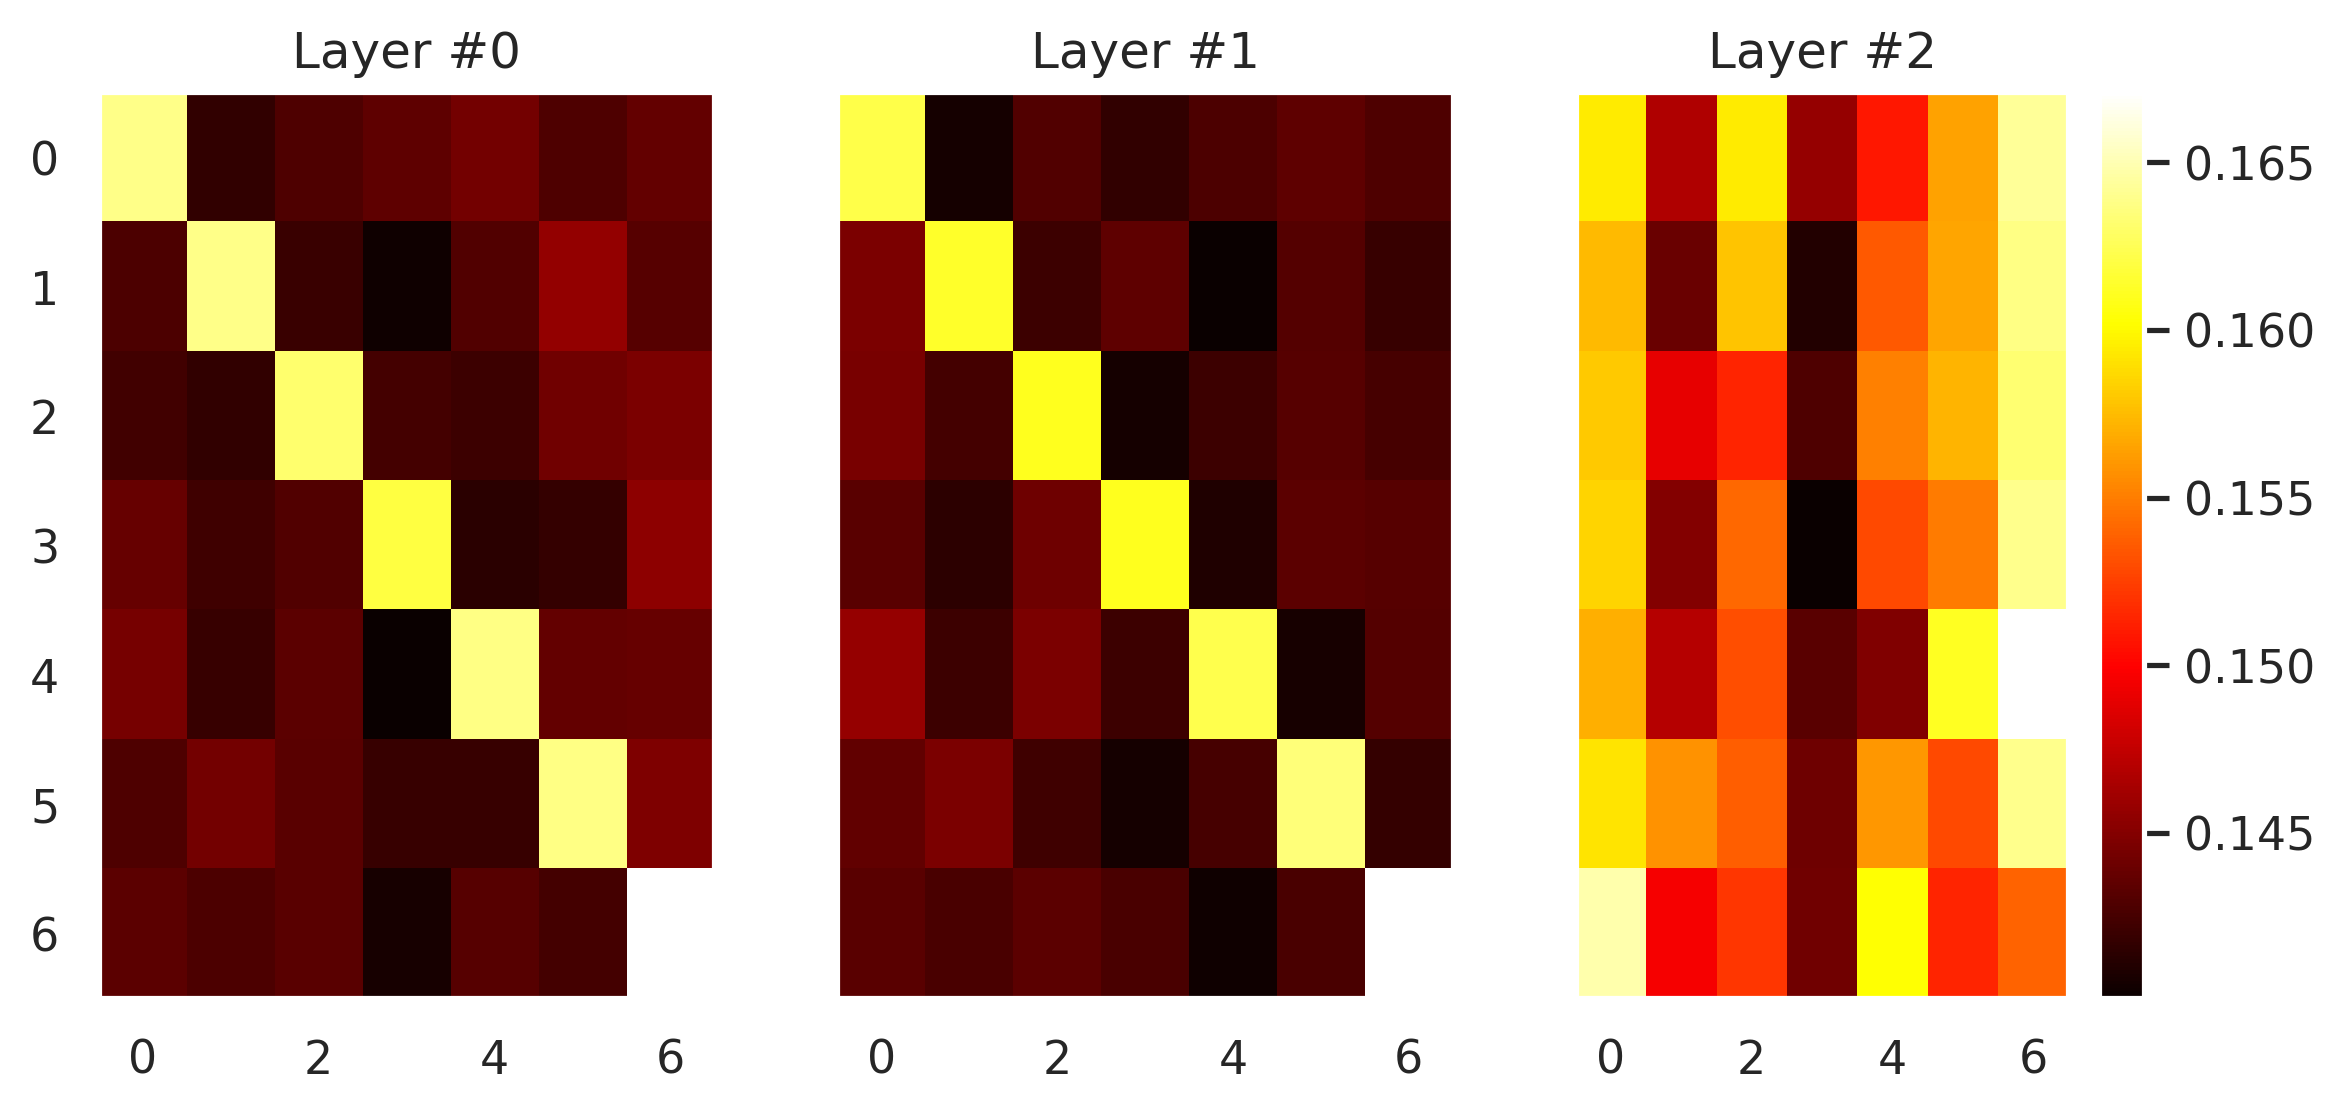

In [13]:
price_dynamics_att = price_dynamics_att_wts_mean.max(1)
num_price_dynamics_layers = price_dynamics_att.shape[0]

fig, axs = plt.subplots(nrows=1, ncols=num_price_dynamics_layers, figsize=(num_price_dynamics_layers*3,4), dpi=300, sharex=True, sharey=True)
axs = axs.reshape(-1)
for i in range(num_price_dynamics_layers):
    ax = axs[i]

    img = ax.imshow(price_dynamics_att[i], cmap='hot', interpolation='nearest')
    ax.title.set_text(f'Layer #{i}')
    ax.axis("tight")
    ax.grid(False)

fig.colorbar(img)

In the early layers the attention price dynamics is mainly focal on the corresponding days. In the final layes the attention goes more global across all days.

### Price Marker Attention
After learning price dynamics for each airline we want to bring in effects of marker on the price prediction.
As visualized in the plots below, the initial layers are more focused on the an individual airline for price determination while the layers have a wider attention.

/is/ps3/nghorbani/opt/anaconda3/envs/apo/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


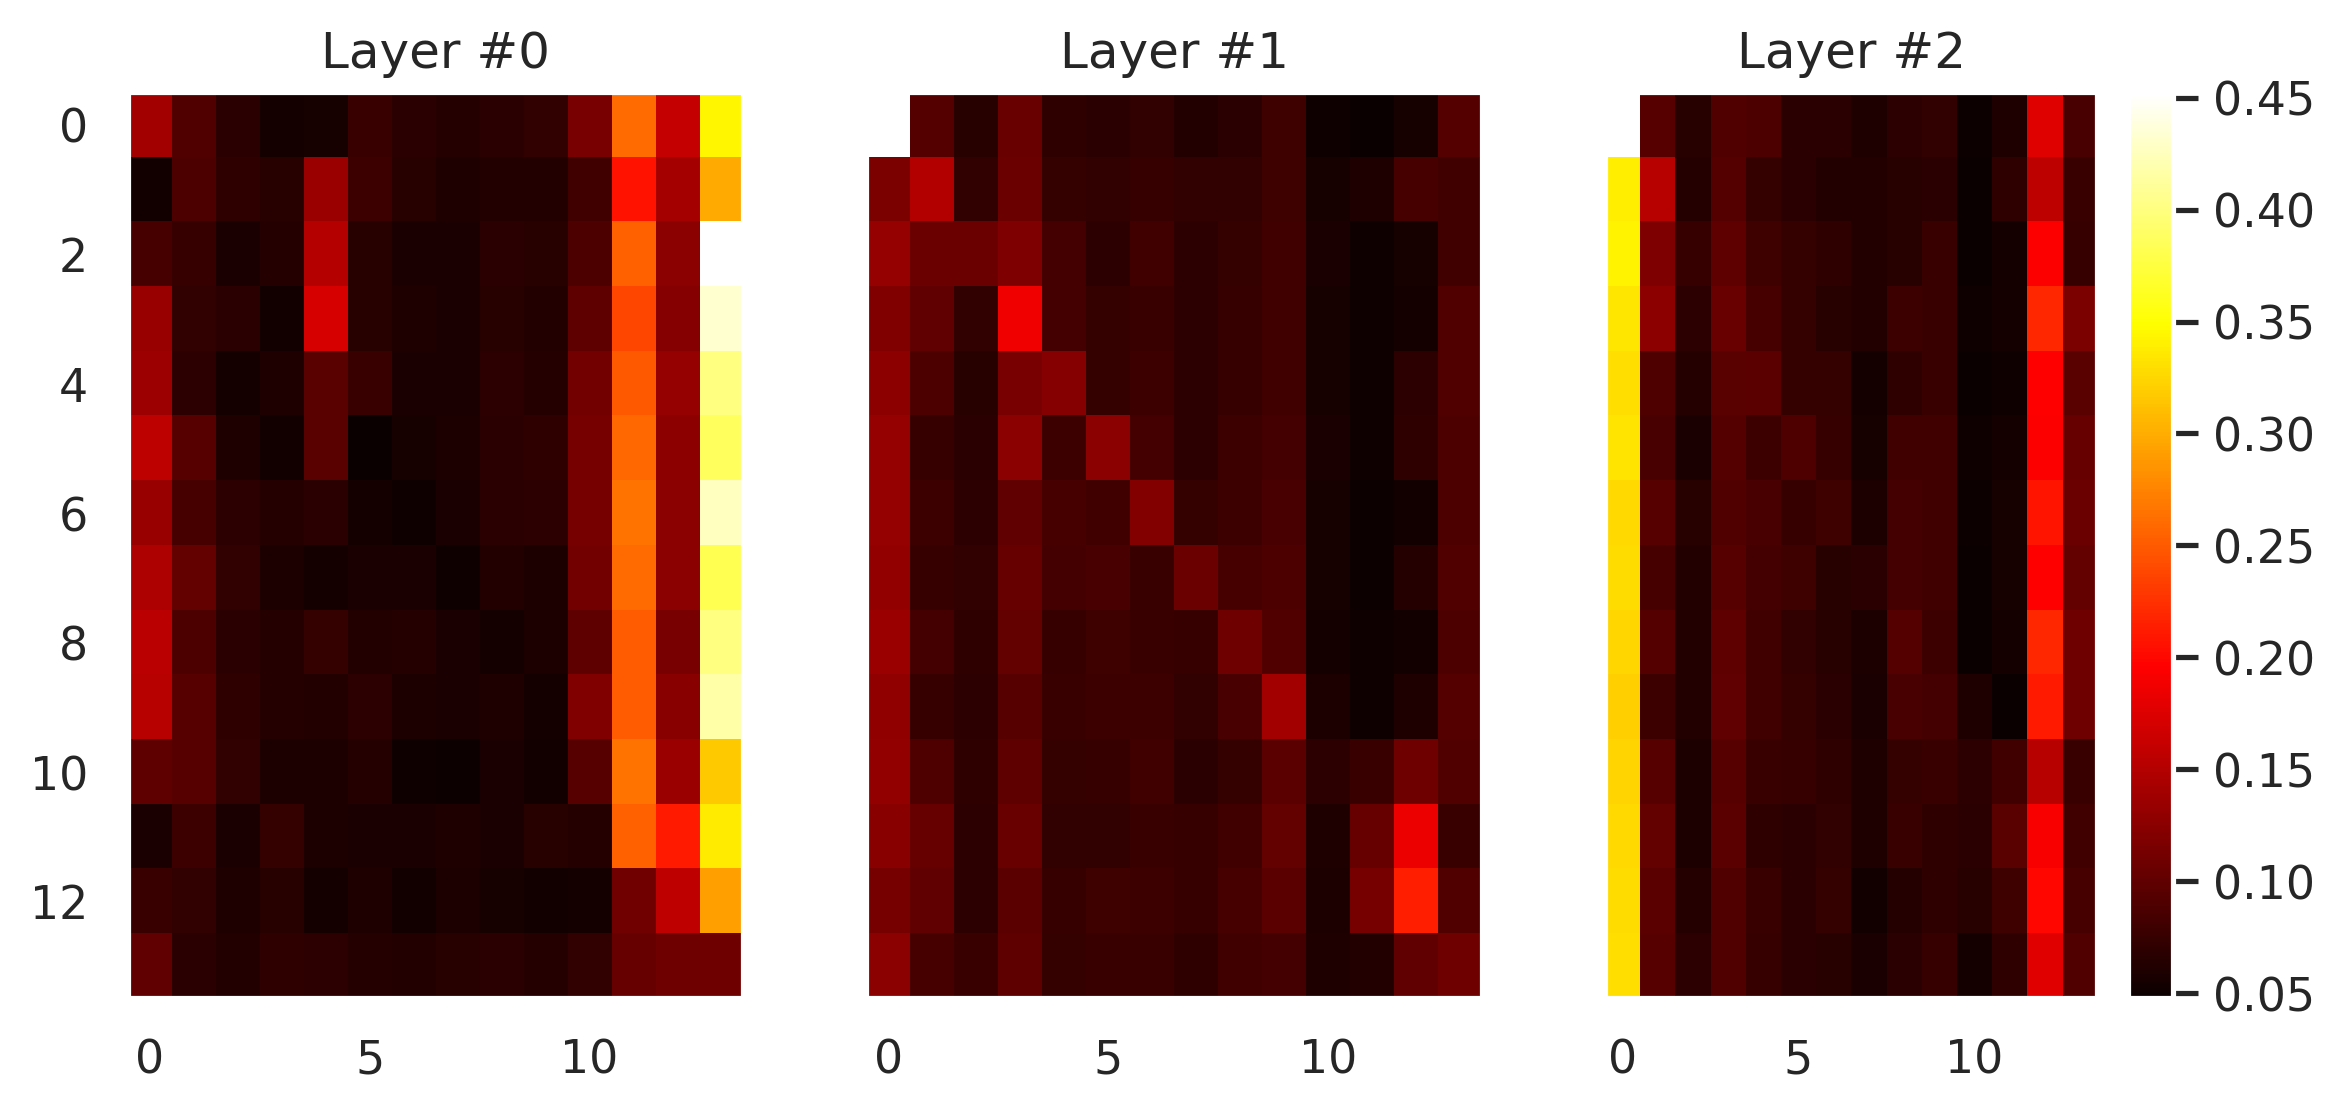

In [14]:
price_market_att = price_market_att_wts_mean.max(1)
num_price_market_att_layers = price_market_att_wts_mean.shape[0]

fig, axs = plt.subplots(nrows=1, ncols=num_price_market_att_layers, figsize=(num_price_market_att_layers*3,4), dpi=300, sharex=True, sharey=True)
axs = axs.reshape(-1)
for i in range(num_price_market_att_layers):
    ax = axs[i]

    img = ax.imshow(price_market_att[i], cmap='hot', interpolation='nearest')
    ax.title.set_text(f'Layer #{i}')
    ax.axis("tight")
    ax.grid(False)

fig.colorbar(img)